# Blogger Clustering Project + LDA Model (explore the thematic structure of documents)

2 datasets are available:

 - one describes the general characteristics of 107 bloggers
 - the second includes data about the publications of these bloggers

**Task**: using the clustering method to select for further publication those bloggers who perform their work more actively and efficiently.

I'll start by importing all the libraries necessary for work

In [466]:
# import of necessary libraries

from yellowbrick.cluster import KElbowVisualizer
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline  
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords
stemmer = nltk.SnowballStemmer("english")
wordnet_lemmatizer = WordNetLemmatizer()
import gensim
from gensim import corpora
sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


I will also prepare some functions for converting text data

In [467]:
# # useful modules
def basic_details(df):
    """returns basic statistics for dataset - % of zero, nan and unique values"""
    b = pd.DataFrame()
    b['Missing value, %'] = round(df.isnull().sum()/df.shape[0]*100,4)
    b['Zero value, %'] = round(df.isin([0]).sum() /df.shape[0]*100,4)
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('`"\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    text = ' '.join(wordnet_lemmatizer.lemmatize(word)  for word in text.split(' '))
    text = word_tokenize(text)
    return text

def create_corpus(df):
    '''text to tokens'''
    corpus=[]
    for tweet in tqdm(df.text_clean):
        words=[word for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus

Next, I will load the first dataset with general data about the authors and convert the names of the features

In [468]:
#load, clean, rename for autors file
df = pd.read_csv('autors.csv') # 107 raws /6 cols
df.rename(columns = {"Average Number Of Words In Posts (without stopwords)":'wordsNumNoStop',"Average Number Of Words In Posts":'wordsNum'}, inplace = True)
usecols_autors = ['Author ID','wordsNumNoStop','wordsNum','MEIBI','MEIBIX'] 
df = df[usecols_autors]
df.sample()

,Author ID,wordsNumNoStop,wordsNum,MEIBI,MEIBIX
21,22,4.317936,5.921872,13,13


About features:

 - Author ID - author's unique identifier
 - MEIBI and MEIBIX metrics identify the top influential bloggers
 - wordsNumNoStop - Average Number Of Words In Posts (without stopwords)
 - wordsNum - Average Number Of Words In Posts (with stopwords)


In [469]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Author ID,107.0,54.000000,31.032241,1.000000,27.500000,54.000000,80.500000,107.000000
wordsNumNoStop,107.0,4.271868,0.294846,3.233319,4.089780,4.234233,4.406861,5.105769
wordsNum,107.0,5.820448,0.311643,4.368871,5.656561,5.840711,5.990137,6.637500
MEIBI,107.0,7.205607,15.200384,0.000000,1.000000,2.000000,7.000000,114.000000
MEIBIX,107.0,7.205607,15.194797,0.000000,1.000000,2.000000,7.000000,114.000000


From the presented table, the following conclusions can be drawn:

 - In total, the table contains 107 values for each of the four variables, which may indicate that the sample is not very large.

 - wordsNumNoStop and wordsNum represent the number of words in articles with and without stop words (words that occur frequently in the language and do not carry much information). The average value of wordsNumNoStop is 4.27, and wordsNum is 5.82, which may indicate that the articles are quite short, consisting of about 4-6 words.

 - MEIBI and MEIBIX are likely to be two different variables that may be related to measurements of certain characteristics. The mean value of both variables is 7.21, which may indicate that these characteristics are quite low.

I move on to the next dataset and first convert the names of the features into a convenient form

In [470]:

df1 = pd.read_csv('posts.csv') #19464, 9
df1.rename(columns = {"Blogger's ID":'Author ID',"Number of retrieved inlinks":'links'}, inplace = True)
df1.rename(columns = {"Number of retrieved comments":'comments',"Number of comments":'commentsNum'}, inplace = True)

df1.sample(2)

,Post ID,Title,Blogger's Name,Author ID,commentsNum,Content,Date,links,comments
10384,10385,Blip.tv Gets Some Safety Money From Bain,Robin Wauters,11,18,New York-based online television network blip....,2008-10-21,6,10
12548,12549,Friday Survey: Do You Own An iPhone?,Mark Hendrickson,53,78,It&#8217;s coming up on a year since the iPhon...,2008-05-16,0,60


In [471]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19464 entries, 0 to 19463
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Post ID         19464 non-null  int64 
 1   Title           19459 non-null  object
 2   Blogger's Name  19464 non-null  object
 3   Author ID       19464 non-null  int64 
 4   commentsNum     19464 non-null  int64 
 5   Content         19383 non-null  object
 6   Date            19464 non-null  object
 7   links           19464 non-null  int64 
 8   comments        19464 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 1.3+ MB


Basic statistics as for zero values and NaN:

In [472]:
basic_details(df1)

,"Missing value, %","Zero value, %",N unique value,dtype
Post ID,0.0000,0.0000,19464,int64
Title,0.0257,0.0000,19269,object
Blogger's Name,0.0000,0.0000,107,object
Author ID,0.0000,0.0000,107,int64
commentsNum,0.0000,13.7998,439,int64
Content,0.4162,0.0000,19265,object
Date,0.0000,0.0000,1720,object
links,0.0000,10.3627,100,int64
comments,0.0000,2.4147,346,int64


Features description for 2nd dataset:

 - Post ID - post's unique identifier
 - Title - title of post
 - Blogger's Name - author's name
 - Blogger's ID - post's unique identifier (for further data concatenation)
 - commentsNum - number of post comments
 - comments - number of retrieved comments
 - Content - post content
 - Date - date of post
 - links - number of retrieved inlinks

I want to add a new feature to the data set: the number of publications of the author during last six months. Perhaps this will help me understand the intensity of the author.

In [473]:
from datetime import datetime, timedelta

df1['Date'] = pd.to_datetime(df1['Date'])

# define the end date as the maximum date in the dataset
end = max(df1['Date'])



# define the start date as 6 months ago from the end date
start = end - pd.DateOffset(months=6)
df_filtered = df1[df1['Date'].between(start,end)]

# Grouping posts by bloggers and counting the number of posts in each group
counts = df_filtered.groupby('Author ID')['Date'].count().reset_index()
counts.columns = ['Author ID', 'pubLast6months']

# We merge the result with the original dataframe using merge
df1 = pd.merge(df1, counts, on='Author ID',how='left')

# Fill in missing values with zeros
df1['pubLast6months'] = df1['pubLast6months'].fillna(0)
df1.shape



(19464, 10)

In [474]:
basic_details(df1)

,"Missing value, %","Zero value, %",N unique value,dtype
Post ID,0.0000,0.0000,19464,int64
Title,0.0257,0.0000,19269,object
Blogger's Name,0.0000,0.0000,107,object
Author ID,0.0000,0.0000,107,int64
commentsNum,0.0000,13.7998,439,int64
Content,0.4162,0.0000,19265,object
Date,0.0000,0.0000,1720,datetime64[ns]
links,0.0000,10.3627,100,int64
comments,0.0000,2.4147,346,int64
pubLast6months,0.0000,14.2057,31,float64


Then I combine the title and text of the posts into corp feature and I'll add some new features to dataframe and drop useless features

In [475]:
# combine title & text
df1['corp'] = df1.Title.fillna('') + " " + df1.Content.fillna('')
df1['corp_len'] = df1['corp'].apply(lambda x: len(x.split(' '))) # text len
df1['autorActivity'] = df1.groupby('Author ID')['Author ID'].transform('count') # how many autor's posts?
df1['commentsTotal'] = df1.commentsNum+df1.comments # sum of 1-st level and other comments
df1 = df1.drop(['Title','Content','Post ID',"Blogger's Name",'Date','comments','commentsNum'], axis=1)

In [476]:
df1.describe()

,Author ID,links,pubLast6months,corp_len,autorActivity,commentsTotal
count,19464.000000,19464.000000,19464.000000,19464.000000,19464.000000,19464.000000
mean,18.742756,9.957254,362.556926,376.745838,2225.390567,85.449137
std,29.724150,14.188437,234.229607,418.626556,1716.086173,110.678427
min,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000
25%,2.000000,2.000000,82.000000,193.000000,1260.000000,30.000000
50%,4.000000,5.000000,433.000000,289.000000,1435.000000,54.000000
75%,11.000000,12.000000,469.000000,430.000000,4903.000000,101.000000
max,107.000000,100.000000,700.000000,10958.000000,4903.000000,3183.000000


From the presented table, the following conclusions can be drawn:

 - The table shows statistics for 19464 blog authors.
 - The average value for citations is 9.96 and the maximum value is 100, which means that most authors add relatively few citations to their publications.
 - The average value of pubLast6months is 362.56 and the maximum is 700, which means that the authors have published a relatively large number of publications in the last 6 months.
 - The average value of corp_len is 376.75, and the maximum value is 10958, which means that the length of publications among authors varies greatly.
 - The average value of autorActivity is 2225.39 and the maximum value is 4903, which means that most of the authors are actively participating in the life of the blogs and leaving comments.
 - The average value of commentTotal is 85.45 and the maximum is 3183, which means that the number of comments among authors varies greatly, and there are authors who have much more comments than others.

In [477]:
df1.sample(5)

,Author ID,links,pubLast6months,corp,corp_len,autorActivity,commentsTotal
13842,89,5,0.0,Yahoo Relaunches Yahoo Video Amid the turmoil ...,151,1275,16
19006,2,5,433.0,Omnidrive&#039;s Online Storage Actually Works...,132,4903,31
1843,3,2,468.0,"Google Now Tracking The Flu, City By City. So...",198,2685,13
3815,2,1,433.0,Google Figured Out Where New Zealand Is Last w...,111,4903,37
13763,2,35,433.0,Facebook Targets FriendFeed; Opening Up The Ne...,258,4903,104


Next, I want to convert all of each author's posts into a list of words that can describe the author's area of interest. In other words, to identify the TOP words of each of them, so that in the future the client can choose the author by relevant keywords in publications.

gensim.models.ldamodel.LdaModel -  is a class that represents an implementation of the Latent Dirichlet Allocation (LDA) model in the Gensim library. LDA is a probabilistic generative model that allows you to explore the thematic structure of documents.

LdaModel trains LDA on a set of documents and allows you to extract thematic distributions in documents. It takes several parameters such as:

 - corpus: a set of documents presented as lists of terms
 - id2word: A dictionary that assigns a unique integer identifier to each term.
 - num_topics: number of topics to retrieve
 - random_state: initializing the random number generator for reproducible results
 - update_every: number of processed documents to update the model
 - chunksize: number of documents processed at one time
 - pass: number of passes through the dataset to train the model
 - alpha: A model parameter that controls the distribution of topics in the document.
 - per_word_topics: A flag indicating whether to retrieve the topic distribution for each word in the document.
 
LdaModel also provides methods for applying the trained model to new documents and extracting topic distributions.

In [478]:

# Group the dataset by blogger ID
grouped = df1.groupby('Author ID')

# Create an empty list to store the results
results = []

# Iterate over each group
for name, group in grouped:
    # Concatenate all the blogger's posts into one text
    text = ' '.join(group['corp'])
    
    # Clean the text 
    preprocessed_text = clean_text(text)
    
    # Create a dictionary
    dictionary = corpora.Dictionary([preprocessed_text])
    
    # Create a corpus
    corpus = [dictionary.doc2bow(preprocessed_text)]
    
    # Apply the LDA algorithm to extract topics
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=1, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
    
    # Add the obtained topic to the results list
    results.append((name, lda_model.print_topics()[0][1]))
    
# Create a new dataset with a new feature
new_df = pd.DataFrame(results, columns=['Author ID', 'Topic'])

# Function to create a string with the top words
def top_words(topic):
    return ', '.join([word.split('*')[1].strip() for word in topic.split('+')])

# Apply the function to the 'Topic' column
new_df['Topic'] = new_df['Topic'].apply(lambda x: top_words(x))
new_df.sample(3)


,Author ID,Topic
1,2,"""user"", ""company"", ""new"", ""google"", ""’"", ""like..."
71,72,"""advertising"", ""’"", ""google"", ""ad"", ""content"",..."
2,3,"""million"", ""google"", ""search"", ""video"", ""one"",..."


And now I'd like to combine all datasets into one for further analytics

In [479]:

# group all features by autors and getting median
df1 = (df1.groupby(['Author ID'], as_index=False)
                .agg(commentsTotal_median = ('commentsTotal','median'),links_median = ('links','median'),
                corp_len_median = ('corp_len','median'),autorActivity = ('autorActivity','median'), pubLast6months = ('pubLast6months','median')))

In [480]:
# merge all files 
df = pd.merge(df, df1, on='Author ID', how='inner')
df = pd.merge(df, new_df, on='Author ID', how='inner')
df = df.set_index('Author ID')
df.sample()

,wordsNumNoStop,wordsNum,MEIBI,MEIBIX,commentsTotal_median,links_median,corp_len_median,autorActivity,pubLast6months,Topic
Author ID,,,,,,,,,,
106,4.067162,5.650984,4,4,62.0,6.0,269.5,68.0,0.0,"""site"", ""user"", ""company"", ""video"", ""new"", ""sa..."


So, the data set for further analytics has been received and I'm moving on to the next step.

<Axes: >

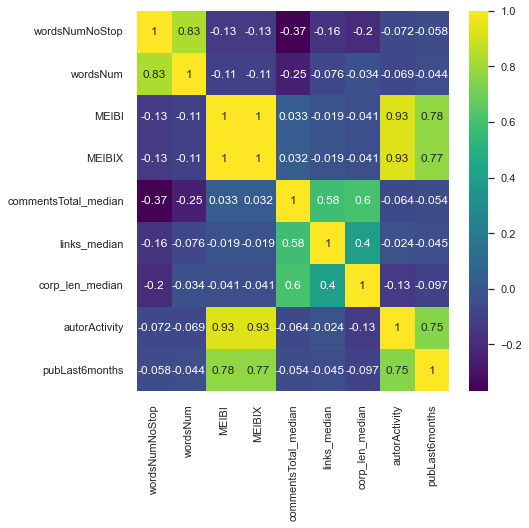

In [481]:
# correlation matrix between features
fig_dims = (7, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(df.corr(), annot=True, cmap='viridis')

In [482]:
df.describe(percentiles=[0.01, 0.25,0.5,0.75, 0.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
wordsNumNoStop,107.0,4.271868,0.294846,3.233319,3.628533,4.089780,4.234233,4.406861,5.037697,5.105769
wordsNum,107.0,5.820448,0.311643,4.368871,4.948170,5.656561,5.840711,5.990137,6.572308,6.637500
MEIBI,107.0,7.205607,15.200384,0.000000,0.000000,1.000000,2.000000,7.000000,65.400000,114.000000
MEIBIX,107.0,7.205607,15.194797,0.000000,0.000000,1.000000,2.000000,7.000000,64.520000,114.000000
commentsTotal_median,107.0,70.121495,57.407548,0.000000,1.530000,34.000000,53.500000,81.750000,240.200000,265.000000
links_median,107.0,6.803738,11.991301,0.000000,0.000000,2.000000,4.000000,6.500000,53.580000,98.000000
corp_len_median,107.0,470.056075,384.281929,50.000000,64.920000,265.500000,343.000000,483.750000,1589.720000,2469.000000
autorActivity,107.0,181.906542,612.560148,1.000000,1.000000,2.000000,6.000000,42.000000,2633.160000,4903.000000
pubLast6months,107.0,39.112150,129.221641,0.000000,0.000000,0.000000,1.000000,8.000000,663.980000,700.000000


Since MEIBI and MEIBIX are multicollinear to each other, I decide not to use  MEIBIX in further analysis.

Since wordsNumNoStop feature has low variability, I decided to exclude it from further analysis.


In [483]:
X_numerics = df[['commentsTotal_median','links_median','corp_len_median','pubLast6months','MEIBI','autorActivity']]

Next, I remove the outliers by cutting off the tails at the 99th percentile

In [484]:
# remove outliers
X_numerics = X_numerics[X_numerics.links_median<90]
X_numerics = X_numerics[X_numerics.corp_len_median.between(100,1600)]
X_numerics = X_numerics[X_numerics.MEIBI<100]


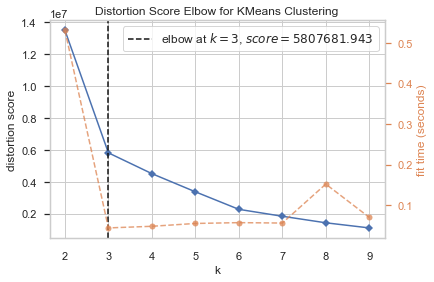

In [485]:
# number of clusters based on elbow method
model = KMeans(random_state=2020)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

There I use the elbow method to determine the optimal number of clusters for KMeans.

The algorithm works as follows: for each value of k (the number of clusters), the KMeans algorithm is run and the sum of the squared distances between each observation and its center of gravity is calculated. Then a curve is drawn on the graph showing the values of the sum of the squared distances depending on the number of clusters.

The idea of the elbow method is to find the value of k after which the sum of the squared distances stops decreasing significantly when new clusters are added. On the graph, this may look like an elbow (elbow), where the optimal number of clusters is at the "elbow" point.

The code uses the Yellowbrick library to visualize the process and plots the sum of squared distances versus the number of clusters. The user is given the opportunity to select a range of k values for plotting.

KMeans is one of the most common clustering algorithms that allows you to group observations into k clusters based on their similarity. The number of clusters is determined in advance, and the algorithm iteratively minimizes the sum of squared distances between each observation and the cluster centroid to determine the optimal distribution of clusters. KMeans requires numerical features and assumes that the clusters are spherical and have the same variance.

In [486]:
# Create cluster feature
kmeans = KMeans(n_clusters=3) # the optimal number of clusters that we obtained in the previous step
X_numerics["Cluster"] = kmeans.fit_predict(X_numerics)
X_numerics["Cluster"] = X_numerics["Cluster"].astype("category")
X_numerics.head()

,commentsTotal_median,links_median,corp_len_median,pubLast6months,MEIBI,autorActivity,Cluster
Author ID,,,,,,,
1,56.0,5.0,333.0,469.0,43,1821.0,1
3,34.0,7.0,317.0,468.0,56,2685.0,1
4,54.0,2.0,187.0,158.0,22,698.0,0
5,83.0,6.0,357.0,700.0,66,1435.0,1
6,74.5,4.0,427.5,61.0,16,148.0,0


Next, I turn to the visualization of the obtained values.

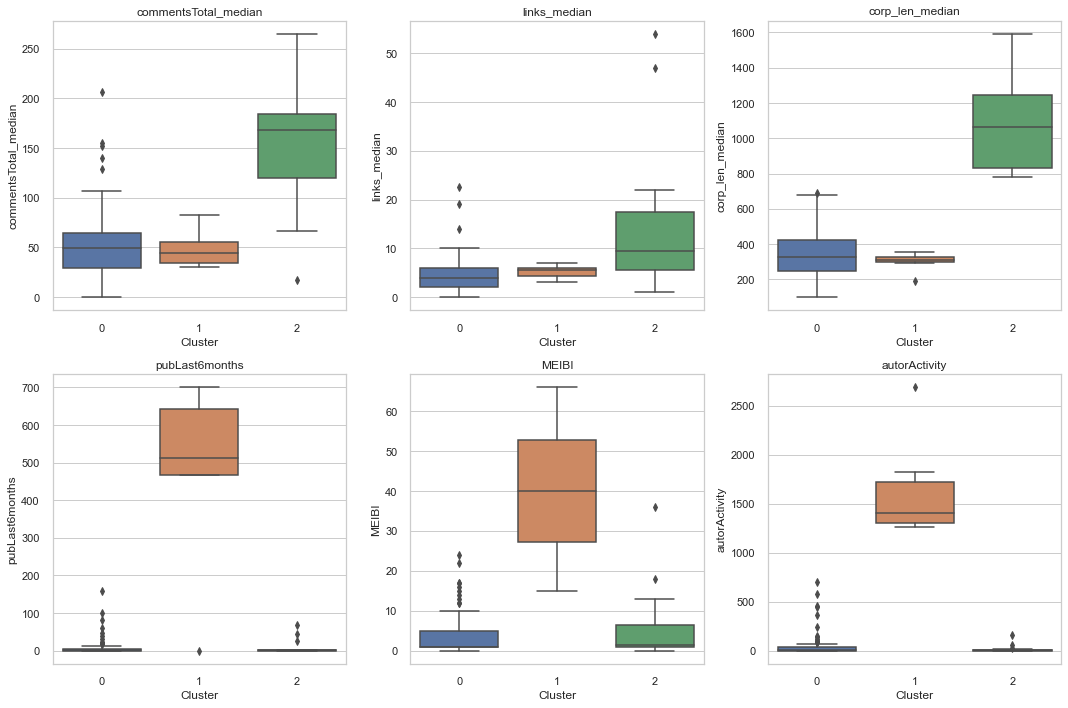

In [487]:


# set the list of features to be displayed
features = ['commentsTotal_median','links_median','corp_len_median','pubLast6months','MEIBI','autorActivity']

# set the number of rows and columns to display graphs
rows = 2
cols = 3

# create subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,10))

# for each feature, we build a boxplot by cluster number
for i, feature in enumerate(features):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    sns.boxplot(x='Cluster', y=feature, data=X_numerics, ax=ax)
    ax.set_title(feature)
    
plt.tight_layout()
plt.show()

Conclusions that suggest themselves:

- Features "pubLast6months", "MEIBI", "autorActivity" have the same value and reflect the degree of the Author's activity in terms of the number of posts written. The most "productive" authors are in subgroup 1 of the cluster. And if the criterion for the client when choosing an Author is the number of posts per unit of time, then based on the received picture, I will recommend to him the Authors of subgroup 1.

- From the first three horizontal charts, we can conclude that the Authors of subgroup 0 write the longest posts and collect the most links and comments. If the Client, when choosing an Author, was guided by obtaining the maximum number of links and comments, I would recommend him to contact the Authors from subgroup 0.

- However, as can be seen from diagrams 4 and 6, those who have the most links and comments have the least activity in terms of the number of posts per unit of time. And we will need to be creative in choosing the golden mean.

The longer text -  the higher number of comments on posts:

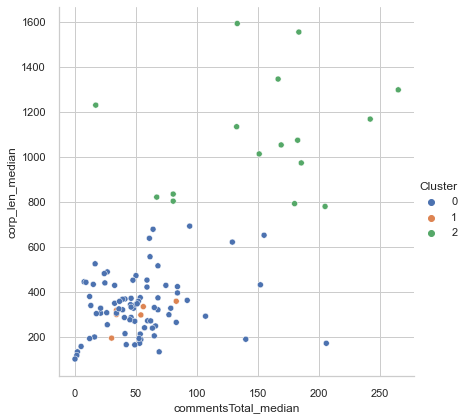

In [488]:
sns.relplot(
    x="commentsTotal_median", y="corp_len_median", hue="Cluster", data=X_numerics, height=6,)

Active authors (who write a lot of texts) do not write long posts:

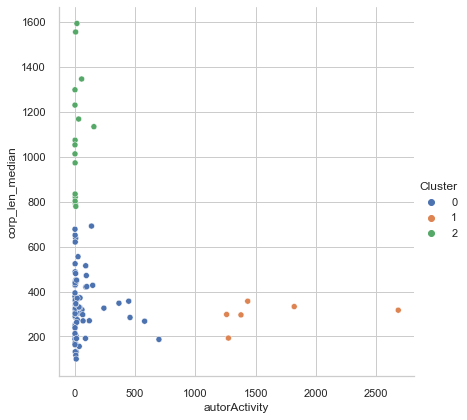

In [489]:
sns.relplot(x="autorActivity", y="corp_len_median", hue="Cluster", data=X_numerics, height=6,)

The distribution of Authors by clusters is as follows:

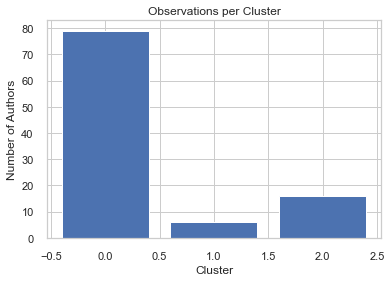

In [490]:
cluster_counts = X_numerics['Cluster'].value_counts().sort_index()
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Authors')
plt.title('Observations per Cluster')
plt.show()

Conclusion: depending on the goal of the client, I will recommend authors from subgroup 0 or 1. We also have a Topic function in the df dataset, for which I can make additional recommendations for Authors depending on their area of interest.